<a href="https://colab.research.google.com/github/kundajelab/mfinkels_work/blob/master/Regression_featureInteractions_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [7]:
from google.colab import files
uploaded = files.upload()

Saving sci09.v2_Gmeb1_1745.pwm.txt to sci09.v2_Gmeb1_1745.pwm (1).txt


In [8]:
!rm -r simdna
!git clone https://github.com/kundajelab/simdna.git

Cloning into 'simdna'...
remote: Enumerating objects: 879, done.
remote: Total 879 (delta 0), reused 0 (delta 0), pack-reused 879
Receiving objects: 100% (879/879), 2.90 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (518/518), done.


In [9]:
!pip install simdna/
!pip install deeplift

Processing ./simdna
  Stored in directory: /tmp/pip-ephem-wheel-cache-Xz7vSA/wheels/90/3e/de/276b5ab0a9cbb5d9e10987f6cef9d3472f60cf61f5b32c8bc4
Successfully built simdna
  Found existing installation: simdna 0.4.3.1
    Uninstalling simdna-0.4.3.1:
      Successfully uninstalled simdna-0.4.3.1


In [0]:
import simdna
from simdna import synthetic, random
class PoissonQuantityGenerator(synthetic.AbstractQuantityGenerator):
    """Generates values according to a poisson distribution.
    Arguments:
        mean: the mean of the poisson distribution
    """

    def __init__(self, mean, name=None):
        self.mean = mean
        super(PoissonQuantityGenerator, self).__init__(name)

    def generateQuantity(self):
        """See superclass.
        """
        sample = random.poisson(self.mean)
        if sample <= 5:
          return sample
        else:
          return 5

    def getJsonableObject(self):
        """See superclass.
        """
        return "poisson-" + str(self.mean)

In [11]:
#set up the simulation
import numpy as np
from collections import OrderedDict
from simdna.util import DEFAULT_LETTER_TO_INDEX
simdna.random.seed(1234)

seqLength = 100
MU = 0.1

background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
letter_distribution = simdna.util.DiscreteDistribution(background_letter_freq)

class PWM(object):

    def __init__(self, name, letterToIndex=DEFAULT_LETTER_TO_INDEX):
        self.name = name
        self.letterToIndex = letterToIndex
        self.indexToLetter = dict(
            (self.letterToIndex[x], x) for x in self.letterToIndex)
        self._rows = []
        self._finalised = False

    def addRow(self, weights):
        if (len(self._rows) > 0):
            assert len(weights) == len(self._rows[0])
        self._rows.append(weights)

    def addRows(self, matrix):
        for row in matrix:
            self.addRow(weights=row)
        return self

    def finalise(self, pseudocountProb=0.001):
        assert pseudocountProb >= 0 and pseudocountProb < 1
        # will smoothen the rows with a pseudocount...
        self._rows = np.array(self._rows)
        self._rows = self._rows * \
            (1 - pseudocountProb) + float(pseudocountProb) / len(self._rows[0])
        self._logRows = np.log(self._rows)
        self._finalised = True
        self.bestPwmHit = self.computeBestHitGivenMatrix(self._rows)
        self.pwmSize = len(self._rows)
        return self

    def getBestHit(self):
        return self.bestPwmHit

    def computeBestHitGivenMatrix(self, matrix):
        return "".join(self.indexToLetter[x] for x in (np.argmin(matrix, axis=0)))

    def getRows(self):
        if (not self._finalised):
            raise RuntimeError("Please call finalised on " + str(self.name))
        return self._rows

    def sampleFromPwm(self, bg=None):
        if (not self._finalised):
            raise RuntimeError("Please call finalised on " + str(self.name))

        sampledLetters = []
        logOdds = 0
        probArr = np.array([1/(1 + np.exp(x - MU)) for x in np.transpose(self._rows)])
        probArrNormed = probArr/probArr.sum(axis = 1)[:, None]
        for row in probArrNormed:
            sampledIndex = synthetic.util.sampleFromProbsArr(row)
            letter = self.indexToLetter[sampledIndex]
            if (bg is not None):
                logOdds += np.log(row[sampledIndex]) - np.log(bg[letter]) 
            sampledLetters.append(letter)
        sampledHit = "".join(sampledLetters)
        if (bg is not None):
            return (sampledHit, logOdds)
        else:
            return sampledHit 

    def sampleFromPwmAndScore(self, bg):
        return self.sampleFromPwm(bg=bg)

    def __str__(self):
        return self.name + "\n" + str(self._rows)

          
class AbstractLoadedMotifs(object):
    """Class representing loaded PWMs.
    A class that contains instances of ``pwm.PWM`` loaded from a file.
    The pwms can be accessed by name.
    Arguments:
        loadedMotifs: dictionary mapping names of motifs
    to instances of ``pwm.PWM`` 
    """

    def __init__(self, loadedMotifs):
        self.loadedMotifs = loadedMotifs

    def getPwm(self, name):
        """Get a specific PWM.
        Returns:
            The ``pwm.PWM`` instance with the specified name.
        """
        return self.loadedMotifs[name]

    def addMotifs(self, abstractLoadedMotifs):
        """Adds the motifs in abstractLoadedMotifs to this.
        Arguments:
            abstractLoadedMotifs: instance of :class:`.AbstractLoadedMotifs`
        Returns:
            self, as a convenience
        """
        self.loadedMotifs.update(abstractLoadedMotifs.loadedMotifs)
        return self #convenience return
      
class AbstractLoadedMotifsFromFile(AbstractLoadedMotifs):
    """Class representing loaded PWMs.
    A class that contains instances of ``pwm.PWM`` loaded from a file.
    The pwms can be accessed by name.
    Arguments:
        fileName: string, the path to the file to load
        pseudocountProb: if some of the pwms have 0 probability for\
    some of the positions, will add the specified ``pseudocountProb``\
    to the rows of the pwm and renormalise.
    """

    def __init__(self, fileName,
                       pseudocountProb=0.0):
        self.fileName = fileName
        fileHandle = synthetic.util.get_file_handle(fileName)
        self.pseudocountProb = pseudocountProb
        self.loadedMotifs = OrderedDict()
        action = self.getReadPwmAction(self.loadedMotifs)
        synthetic.util.perform_action_on_each_line_of_file(
            file_handle=fileHandle,
            action=action,
            transformation=synthetic.util.trim_newline
        )
        for pwm in self.loadedMotifs.values():
            pwm.finalise(pseudocountProb=self.pseudocountProb)
        super(AbstractLoadedMotifsFromFile, self).__init__(self.loadedMotifs)

    def getReadPwmAction(self, loadedMotifs, matrix):
        """Action performed when each line of the pwm text file is read in.
        This function is to be overridden by a specific implementation.
        It is executed on each line of the file when it is read in, and
        when PWMs are ready they will get inserted into ``loadedMotifs``.
        Arguments:
            loadedMotifs: an ``OrderedDict`` that will be filled with PWMs.
        The keys will be the names of the PWMs and the
        values will be instances of ``pwm.PWM``
        """
        raise NotImplementedError()


class LoadedStormoMotifs(AbstractLoadedMotifsFromFile):
    """A class for reading in a motifs file in the ENCODE motifs format.
    This class is specifically for reading files in the encode motif
    format - specifically the motifs.txt file that contains Pouya's motifs
    (http://compbio.mit.edu/encode-motifs/motifs.txt)
    Basically, the motif declarations start with a >, the first
    characters after > until the first space are taken as the motif name,
    the lines after the line with a > have the format:
    "<ignored character> <prob of A> <prob of C> <prob of G> <prob of T>"
    """

    def getReadPwmAction(self, loadedMotifs):
        """See superclass.
        """
        currentPwm = synthetic.util.VariableWrapper(None)

        def action(inp, lineNumber):
            if (inp.startswith("# ")):
                inp = inp.lstrip("# ")
                inpArr = inp.split(",")
                motifName = inpArr[0]
                currentPwm.var = PWM(motifName)
                loadedMotifs[currentPwm.var.name] = currentPwm.var
            else:
                # assume that it's a line of the pwm
                assert currentPwm.var is not None
                inpArr = inp.split()
                summaryLetter = inpArr[0]
                currentPwm.var.addRow([float(x) for x in inpArr[1:]])
        return action


# def get_motif_embedder(motif_name, zero_prob, the_max, the_min):
#   return synthetic.RepeatedEmbedder(
#             synthetic.SubstringEmbedder(
#                 substringGenerator=synthetic.BestHitPwmFromLoadedMotifs(
#                     loadedMotifs=loadedMotifs,motifName=motif_name),
#                 positionGenerator=synthetic.UniformPositionGenerator(),
#                 name=motif_name),
#             quantityGenerator=synthetic.ZeroInflater(
#                 synthetic.UniformIntegerGenerator(maxVal=the_max,
#                                                   minVal=the_min),
#                 zeroProb=zero_prob),
#             )

# def get_motif_sampler(loadedMotifs, motif_name, zero_prob, mean):
#   return synthetic.RepeatedEmbedder(
#             synthetic.SubstringEmbedder(
#                 substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
#                 positionGenerator=synthetic.UniformPositionGenerator(),
#                 name=motif_name),
#             quantityGenerator=synthetic.ZeroInflater(
#                 synthetic.PoissonQuantityGenerator(mean = 3),
#                 zeroProb=zero_prob),
#             )

def get_motif_sampler(loadedMotifs, motif_name, mean):
  return synthetic.XOREmbedder(
            embedder1 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator= PoissonQuantityGenerator(mean),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name),
                get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name)]),
            embedder2 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator = synthetic.FixedQuantityGenerator(0),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = name)]),
            probOfFirst = 0.5)


def get_single_embedder(loadedMotifs, motif_name):
      return synthetic.SubstringEmbedder(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
                positionGenerator=synthetic.UniformPositionGenerator(),
                name=motif_name)

loadedMotifs = LoadedStormoMotifs(r'''sci09.v2_Gmeb1_1745.pwm.txt''', pseudocountProb=0.001)
pwmObj = loadedMotifs.loadedMotifs.values()[0]
pwm = np.transpose(pwmObj._rows)
name = loadedMotifs.loadedMotifs.keys()[0]

# embedInBackground = synthetic.EmbedInABackground(
#         backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
#             seqLength=seqLength,
#             discreteDistribution=letter_distribution), 
#         embedders=[
#             get_motif_embedder(motif_name="Gmeb1",
#                                zero_prob=0.5,
#                                the_max=3,
#                                the_min=1)]
#     )

embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
            seqLength=seqLength,
            discreteDistribution=letter_distribution), 
        embedders=[
            get_motif_sampler(loadedMotifs = loadedMotifs, motif_name = name,
                               mean = 3)]
    )

numSeqs = 100000 #40K train, 20K valid, 40K test
sequenceSet = synthetic.GenerateSequenceNTimes(embedInBackground, numSeqs)

synthetic.printSequences("simulation.simdata", sequenceSet,
                         includeFasta=True,
                         includeEmbeddings=True,
                         prefix="sim")


In [12]:
!head -100 simulation.simdata

seqName	sequence	embeddings
sim-synth0	AGCTTCCTTTCGGGCGGATTCGACTGCTCGTCTAGGATCTAAAGGGAGCGAGGAGTTTTTCGCACACTAATGCAATCGACCGTGGATTGCAGGTCGGTAG	
sim-synth1	GTGTAAGATCACTTACATGGTTGCACGAACGTCAATACGATTGACGAGCTGAATTTTGGAGTTTTGCTTGCCTATCTTGGCTGCACTCCGAATACGATTT	
sim-synth2	GTCTACTCTGTTGCCCCTCATTCGCAACAGTTCCCTTCAAAGACAGGTCCGTAAAAGGGGATTGGCTGCGCAGTTGATCACGCCTTGCAGTTGCGTGACT	pos-77_sci09.v2_Gmeb1_1745-TCACGCCTTG,pos-46_sci09.v2_Gmeb1_1745-GTCCGTAAAA,pos-2_sci09.v2_Gmeb1_1745-CTACTCTGTT
sim-synth3	TGATAAGTGCAGTTTAGCCATGATTCTGACCATTGCCAGTCGAGTGTAACTTCTACGGACGTCAGGCTTTATTTTACTTGTGATCTCATAGAAGTGTCAA	
sim-synth4	ACAGGGTTAGGATAACGTATTCAGAATATCCAACGATATCTCACGAGCGAATTAGTTGAATAGTAGCAAAAACATTTAGTTACGGGTGCATCAGTAACCA	pos-12_sci09.v2_Gmeb1_1745-TAACGTATTC
sim-synth5	AATACGGCCACGTATATAACTTCAGCAGGATTTCCCCGGATGATAGAACACTGGGAGTAGTTCCTAAACAGACCTGAAACACTTATACTACCTGCAGCTG	
sim-synth6	TCAACGGGATTCTAAGATACGTGCGAGCGAGACGCACAAGCCGACGTCTGGTTACTACGTGCATTATTCTCAGCTTACGTTGATTTTGTACGCTACTGAG	pos-74_sci09.v2_Gmeb1_1745-TTACGT

In [13]:
data = synthetic.read_simdata_file("simulation.simdata")
count = 0
for embeddings in data.embeddings:
  if len(embeddings) > 0:
    count += 1
print(count)

47695


In [0]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])


In [15]:
#CREATE LABELING FUNCTION
labels = []
labelsOracle = []
motifStrengths = [] #elements are dicts (one per sequence) mapping startPos of each motif in sequence to binding energy
for i in range(onehot_data.shape[0]):
  sumVar = 0
  j = 0
  deltadeltaG = {} #dict mapping startPos of motif instance to deltadeltaG of instance
  while j <= (onehot_data.shape[1] - 10):
    deltadeltaG[j] = np.sum(np.multiply(onehot_data[i,j:j+10,:], pwm))
    pStormo = float(1/(1 + np.exp(deltadeltaG[j]- MU)))
    pObs = float(1 - (1 - pStormo*.0000222)*(1-.000001))
    sumVar += pObs
    j += 1
  motifStrengths.append(deltadeltaG)
  expectedCount = sumVar*1000000
  labels.append(np.random.poisson(expectedCount))
  labelsOracle.append(expectedCount)
print(np.amax(labels))

160


In [16]:
print(np.mean(labels))
print(np.mean(labelsOracle))

97.83588
97.81090043515643


In [17]:
#find 4 highest-affinity non-overlapping motifs per sequence
import collections
strongestMotifs = [] #extract sub-dict from each dict in motifStrengths with 4 strongest motif instances
for dic in motifStrengths:
  strongestInSeq = collections.OrderedDict()
  sortedByStrength = sorted(dic.iteritems(), key=lambda (k,v): (v,k)) #sorted by binding energy (lowest first)
  for startPos, energy in sortedByStrength:    
    if not bool(strongestInSeq):
      strongestInSeq[startPos] = energy
    nonOverlapping = True
    for key in strongestInSeq.keys():
      if np.abs(key - startPos) < 10:
        nonOverlapping = False
    if nonOverlapping:
      strongestInSeq[startPos] = energy
    if len(strongestInSeq) == 4:
      strongestMotifs.append(strongestInSeq)
      break
print(strongestMotifs[0:5])

[OrderedDict([(57, 2.5084900000000006), (77, 4.87612), (25, 5.165830000000001), (11, 5.5954000000000015)]), OrderedDict([(26, 2.84815), (41, 4.41658), (85, 5.93506), (8, 6.94405)]), OrderedDict([(77, 2.4085900000000002), (46, 2.66833), (65, 2.8681300000000003), (90, 2.9080899999999996)]), OrderedDict([(56, 1.81918), (73, 7.53346), (37, 7.813180000000001), (2, 8.3926)]), OrderedDict([(12, 1.5294699999999999), (79, 4.31668), (40, 4.986009999999999), (30, 5.735259999999999)])]


In [0]:
train_data, train_labels = onehot_data[:40000], labels[:40000]
valid_data, valid_labels = onehot_data[40000:60000], labels[40000:60000]
test_data, test_labels = onehot_data[-40000:], labels[-40000:]

In [19]:
import numpy as np
np.random.seed(1234)
import keras
from keras.models import Sequential

model = Sequential()
model.add(keras.layers.Conv1D(filters=40, kernel_size=19, input_shape=(100,4)))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.AveragePooling1D(pool_size=10, stride=5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation("relu"))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation("relu"))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("linear"))
model.compile(optimizer="adam", loss="mean_squared_error")

print(np.mean(train_labels,axis=0))

model.fit(x=train_data, y=train_labels,
          batch_size=200,
          epochs=1000,
          validation_data=(valid_data, valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=3)])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
97.823575
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(strides=5, pool_size=10)`
  if __name__ == '__main__':


Train on 40000 samples, validate on 20000 samples
Epoch 1/1000
40000/40000 [==============================] - 6s 154us/step - loss: 1064.0814 - val_loss: 129.8769
Epoch 2/1000
40000/40000 [==============================] - 5s 136us/step - loss: 127.8830 - val_loss: 128.7433
Epoch 3/1000
40000/40000 [==============================] - 5s 137us/step - loss: 127.4898 - val_loss: 129.9723
Epoch 4/1000
40000/40000 [==============================] - 5s 136us/step - loss: 127.5594 - val_loss: 128.5307
Epoch 5/1000
40000/40000 [==============================] - 5s 137us/step - loss: 127.2424 - val_loss: 128.6070
Epoch 6/1000
40000/40000 [==============================] - 5s 136us/step - loss: 126.9870 - val_loss: 127.7390
Epoch 7/1000
40000/40000 [==============================] - 5s 136us/step - loss: 126.4065 - val_loss: 127.8913
Epoch 8/1000
40000/40000 [==============================] - 5s 136us/step - loss: 125.9821 - val_loss: 128.4656
Epoch 9/1000
40000/40000 [===========================

In [20]:
from sklearn.metrics import mean_squared_error

#compute test set auROC
test_preds = model.predict(test_data)

print("MSE is", mean_squared_error(y_true=test_labels,
                      y_pred=test_preds))

print("Oracle MSE is", mean_squared_error(y_true=test_labels,
                      y_pred=labelsOracle[-40000:]))

MSE is 114.25340383838035
Oracle MSE is 97.97159715392914


In [21]:
test_sequences = data.sequences[-40000:]
testStrongestMotifs = strongestMotifs[-40000:]
testOracle = labelsOracle[-40000:]
pwmLength = 10

motif_names = ["A", "B"]
motif_name_to_locs = OrderedDict()
for motif_name in motif_names:
  motif_name_to_locs[motif_name] = []

count = 0
countThreshold = 112
for idx, seq in enumerate(testStrongestMotifs):
    for motif_name in motif_names:
      motif_name_to_locs[motif_name].append([])
    if testOracle[idx] >= countThreshold: 
      count += 1
      motif_name_to_locs[motif_names[0]][-1].append(
            (seq.items()[0][0], seq.items()[0][0] + pwmLength))
      motif_name_to_locs[motif_names[1]][-1].append(
            (seq.items()[1][0], seq.items()[1][0] + pwmLength))
print(count)

958


In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
import scipy, copy
import deeplift
from deeplift.dinuc_shuffle import dinuc_shuffle

np.random.seed(1234)
simdna.random.seed(1234)


original_data = []
original_data_sequences = []
motifA_locs = []
motifB_locs = []
motifA_off_data = []
motifB_off_data = []
AandBoff_data = [] 

motifA_off_sequences = []
motifB_off_sequences = []
AandBoff_sequences = []

dinucshuff1_sequences = []
dinucshuff2_sequences = []
dinucshuff1_Aoff_sequences = []
dinucshuff1_Boff_sequences = []
dinucshuff1_AandBoff_sequences = []
  
indices = []

numTrials = 1000

for idx, (region_sequence, onehot_region,
     region_motifA_locs, region_motifB_locs) in\
  enumerate(zip(test_sequences, test_data,
      motif_name_to_locs[motif_names[0]], motif_name_to_locs[motif_names[1]])):
  if (len(region_motifA_locs) > 0 and len(region_motifB_locs) > 0):
    onehot_region = onehot_region.astype("float32")

    original_data.append(onehot_region)
    original_data_sequences.append(region_sequence)
    motifA_locs.append(region_motifA_locs)
    motifB_locs.append(region_motifB_locs)
    
    region_dinucshuff1_sequence = [dinuc_shuffle(region_sequence) for i in range(numTrials)]
    dinucshuff1_sequences.append(region_dinucshuff1_sequence)
    dinucshuff2_sequences.append([dinuc_shuffle(region_sequence) for i in range(numTrials)])
    
    region_motifA_off = np.array(onehot_region)
    region_motifA_off_sequence = region_sequence
    region_dinucshuff1_Aoff_sequence = region_dinucshuff1_sequence

    for (motifA_start,motifA_end) in region_motifA_locs:
      random_substitute_sequence = "".join(letter_distribution.sample()
                                    for i in range(motifA_end-motifA_start))
      #substitute random sequence for motif A, keeping everything else the same
      region_motifA_off_sequence =(
        region_motifA_off_sequence[:motifA_start] + 
        random_substitute_sequence + region_motifA_off_sequence[motifA_end:])
      region_dinucshuff1_Aoff_sequence = [
          region_dinucshuff1_Aoff_sequence[i][:motifA_start] + 
          random_substitute_sequence +
          region_dinucshuff1_Aoff_sequence[i][motifA_end:] for i in range(numTrials)]
      region_motifA_off = np.vstack((
        region_motifA_off[:motifA_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_motifA_off[motifA_end:]))
    motifA_off_data.append(region_motifA_off)
    motifA_off_sequences.append(region_motifA_off_sequence)
    dinucshuff1_Aoff_sequences.append(region_dinucshuff1_Aoff_sequence)


    region_motifB_off = np.array(onehot_region)
    region_motifB_off_sequence = region_sequence
    region_AandBoff_data = region_motifA_off 
    region_AandBoff_sequence = region_motifA_off_sequence
    region_dinucshuff1_Boff_sequence = region_dinucshuff1_sequence
    region_dinucshuff1_AandBoff_sequence = region_dinucshuff1_Aoff_sequence 

    for (motifB_start,motifB_end) in region_motifB_locs:
      region_AandBoff_data[motifB_start:motifB_end] = 0.0 
      random_substitute_sequence = "".join(letter_distribution.sample()
                                    for i in range(motifB_end-motifB_start))
      region_motifB_off_sequence =(
        region_motifB_off_sequence[:motifB_start] + 
        random_substitute_sequence + region_motifB_off_sequence[motifB_end:])
      region_dinucshuff1_Boff_sequence = [
          region_dinucshuff1_Boff_sequence[i][:motifB_start] + 
          random_substitute_sequence +
          region_dinucshuff1_Boff_sequence[i][motifB_end:] for i in range(numTrials)]
      region_motifB_off = np.vstack((
        region_motifB_off[:motifB_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_motifB_off[motifB_end:]))
      region_AandBoff_sequence =(
        region_AandBoff_sequence[:motifB_start] + 
        random_substitute_sequence + region_AandBoff_sequence[motifB_end:])
      region_AandBoff_data = np.vstack((
        region_AandBoff_data[:motifB_start],
        one_hot_encode_along_channel_axis(random_substitute_sequence),
        region_AandBoff_data[motifB_end:]))
      region_dinucshuff1_AandBoff_sequence = [
          region_dinucshuff1_AandBoff_sequence[i][:motifB_start] + 
          random_substitute_sequence +
          region_dinucshuff1_AandBoff_sequence[i][motifB_end:] for i in range(numTrials)] 
    motifB_off_data.append(region_motifB_off)
    motifB_off_sequences.append(region_motifB_off_sequence)
    dinucshuff1_Boff_sequences.append(region_dinucshuff1_Boff_sequence)
    AandBoff_data.append(region_AandBoff_data) 
    AandBoff_sequences.append(region_AandBoff_sequence)
    dinucshuff1_AandBoff_sequences.append(region_dinucshuff1_AandBoff_sequence)
    
    indices.append(idx)
    
print(len(indices))

958


In [0]:
original_data = np.array(original_data).astype("float32")
motifA_off_data = np.array(motifA_off_data).astype("float32")
motifB_off_data = np.array(motifB_off_data).astype("float32")
AandBoff_data = np.array(AandBoff_data).astype("float32")

original_preds = model.predict(original_data)
motifA_off_preds = model.predict(motifA_off_data)
motifB_off_preds = model.predict(motifB_off_data)
AandBoff_preds = model.predict(AandBoff_data)

new_test_labels = []
for i in indices:
  new_test_labels.append(test_labels[i])

inter


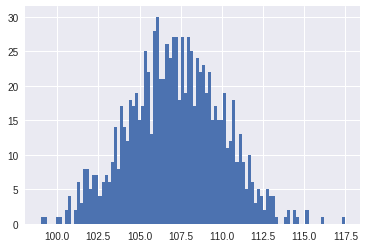

no inter


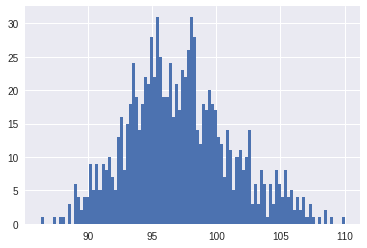

In [24]:
condEffect = original_preds - motifA_off_preds - motifB_off_preds + AandBoff_preds

noInterPreds = original_preds - condEffect

print("inter")
plt.hist(original_preds,bins=100)
plt.show()

print("no inter")
plt.hist(noInterPreds,bins=100)
plt.show()

In [0]:
#dinucleotide-shuffled null distribution

def one_hot_func(x):
  return np.array([one_hot_encode_along_channel_axis(seq) for seq in x])

orig_dinuc_data = [one_hot_func(dinucshuff1_sequences[i]) for i in range(len(indices))]
Aoff_dinuc_data = [one_hot_func(dinucshuff1_Aoff_sequences[i]) for i in range(len(indices))]
Boff_dinuc_data = [one_hot_func(dinucshuff1_Boff_sequences[i]) for i in range(len(indices))]
AandBoff_dinuc_data = [one_hot_func(dinucshuff1_AandBoff_sequences[i]) for i in range(len(indices))]

In [0]:
def label(sequences):
  labels = []
  for i in range(sequences.shape[0]):
    sumVar = 0
    j = 0
    while j <= (sequences.shape[1] - 10):
      deltadeltaG = np.sum(np.multiply(onehot_data[i,j:j+10,:], pwm))
      pStormo = float(1/(1 + np.exp(deltadeltaG - MU)))
      pObs = float(1 - (1 - pStormo*.0000222)*(1-.000001))
      sumVar += pObs
      j += 1
  expectedCount = sumVar*1000000
  labels.append(np.random.poisson(expectedCount))
  return labels 

labels_orig_dinuc = [label(sequences) for sequences in orig_dinuc_data]

original_preds_dinuc = [model.predict(orig_dinuc_data[i]) for i in range(len(indices))]
motifA_off_preds_dinuc = [model.predict(Aoff_dinuc_data[i]) for i in range(len(indices))]
motifB_off_preds_dinuc = [model.predict(Boff_dinuc_data[i]) for i in range(len(indices))]
AandBoff_preds_dinuc = [model.predict(AandBoff_dinuc_data[i]) for i in range(len(indices))]

noInterPreds_dinuc = [np.asarray(motifA_off_preds_dinuc[i] + motifB_off_preds_dinuc[i] - AandBoff_preds_dinuc[i]) for i in range(len(indices))]

In [0]:
import scipy

def empirical_pvalue(val, null_values):
    pval = float(1+sum(float(val) <= np.array(null_values)))/(len(null_values)+1)
    return pval

def gaussian_pvalue(val, null_values, two_sided=True):
    mu, std = scipy.stats.norm.fit(null_values)
    if two_sided:
        pval = np.min([1 - scipy.stats.norm.cdf(val, mu, std), 
                       scipy.stats.norm.cdf(val, mu, std)])
    else:
        pval = 1 - scipy.stats.norm.cdf(val, mu, std)
    return pval

In [28]:
null = [[] for i in range(len(indices))]
for i in range(len(indices)):
  for j, pred in enumerate(original_preds_dinuc[i]):
    null[i].append(float(pred - noInterPreds_dinuc[i][j]))
pvalsEmpirical = [empirical_pvalue(condEffect[i], null[i]) for i in range(len(indices))]
pvalsGaussian = [gaussian_pvalue(condEffect[i], null[i]) for i in range(len(indices))]
print("empirical")
print(len(pvalsEmpirical))

empirical
958


In [29]:
significant_count = sum(1 for i in pvalsEmpirical if i < 0.05)/len(pvalsEmpirical)
count = sum(1 for i in pvalsEmpirical if i == 1/(len(null[0])+1))
print(significant_count)
print(count)

1.0
956


[-1.52587890625e-05, 0.0, -7.62939453125e-06, 0.0, -7.62939453125e-06, -7.62939453125e-06, 7.62939453125e-06, -1.52587890625e-05, 0.0, -1.52587890625e-05]


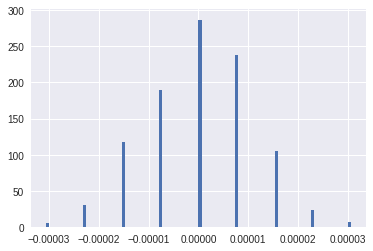

In [30]:
print(null[0][:10])
plt.hist(null[0], bins = 100)
plt.show()

In [31]:
null = []
numTrials = 10000
for i in range(numTrials):
  permuted_labels = np.random.permutation(new_test_labels)
  lossInter = np.square(np.asarray(permuted_labels) - original_preds.flatten())
  lossnoInter = np.square(np.asarray(permuted_labels) - noInterPreds.flatten())
  interBetter = [int(lossInter[i] < lossnoInter[i]) for i in range(len(lossInter))]
  frac = float(np.sum(interBetter))/len(lossInter)
  null.append(frac)

lossInter = np.square(np.asarray(new_test_labels) - original_preds.flatten())
lossnoInter = np.square(np.asarray(new_test_labels) - noInterPreds.flatten())

interBetter = [int(lossInter[i] < lossnoInter[i]) for i in range(len(lossInter))]
frac = float(np.sum(interBetter))/len(lossInter)
print("actual frac")
print(frac)
#pValue = float(np.sum([1 for i in range(len(null)) if null[i] >= frac]))/len(null)
pValueEmp = empirical_pvalue(frac, null)
print("pValue")
print(pValueEmp)

actual frac
0.865344467641
pValue
0.374562543746


[0.8674321503131524, 0.8643006263048016, 0.8590814196242171, 0.8569937369519833, 0.8611691022964509, 0.8590814196242171, 0.8611691022964509, 0.8632567849686847, 0.860125260960334, 0.8653444676409185]


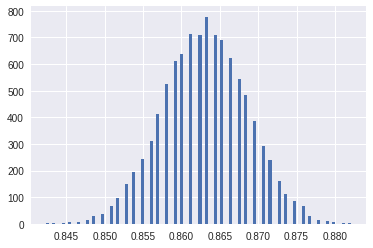

In [32]:
print(null[:10])
from matplotlib import pyplot
plt.hist(null, bins = 100)
plt.show()

WilcoxonResult(statistic=26042.0, pvalue=6.53660794181504e-125)
lossInter


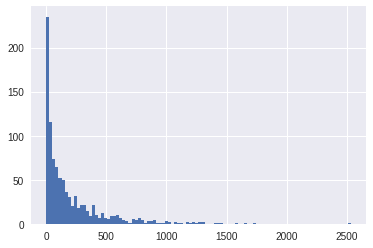

lossnoInter


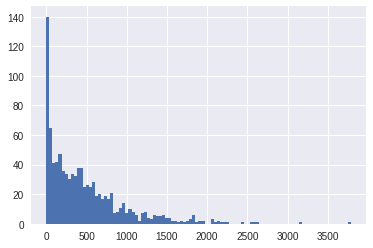

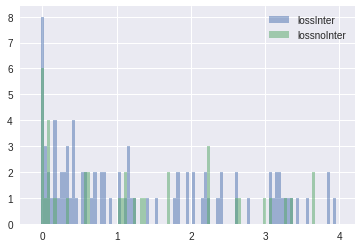

In [33]:
#paired wilcoxon test
import scipy
from scipy import stats

diff = lossInter - lossnoInter

significance = scipy.stats.wilcoxon(diff)
print(significance)

print("lossInter")
plt.hist(lossInter, bins=100)
plt.show()

print("lossnoInter")
plt.hist(lossnoInter, bins=100)
plt.show()

bins = np.linspace(-.1, 4, 100)

pyplot.hist(lossInter, bins, alpha=0.5, label='lossInter')
pyplot.hist(lossnoInter, bins, alpha=0.5, label='lossnoInter')
pyplot.legend(loc='upper right')
pyplot.show()